<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Final_Project/Final_Project_Voting_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voting Analysis

## Imports and Drive Management

In [82]:
# ARGUMENTS
COMPAREMODELS = True
PATCHES = False
CENTERSLICES = True

COLORMODEL = "08_05_finetuning_val76"
GRAYMODEL = "gray_smalldense"



#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import re
import pickle

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  


from pathlib import Path

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import load_model

2.4.1


In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
import random

# path to google drive zip
path_to_zip = '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/artists_recognition_dataset.zip'
# local path to data zip
local_path_to_folder = '/content/artists_recognition_dataset'

# download zip if it does not yet exist in local environment
if not Path(local_path_to_folder.replace(".zip", "")).exists():
  print("Downloading dataset to local environment...")
  !rsync --info=progress2 "{path_to_zip}" .
  print("Extracting dataset in local environment...")
  !unzip -q artists_recognition_dataset.zip | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'
  print("Removing zip to save space...")
  !rm artists_recognition_dataset.zip
else:
  print("Dataset already present in local environment")

# path to folder with images
path = '/content/artists_recognition_dataset/resized/resized'
images_dir = Path(path)

### PARSE DATASET ###

# key = path_to_image:Path
# value = artist:str
painting_artist_dict = {}

# key = artist:str
# value = path_to_image:Path
artist_painting_dict = {}

for image in images_dir.rglob("*"):
  if image.is_file() and str(image).endswith("jpg"):
        # Extract label from filename
        pattern= re.compile(r"(.*)_(\d*).jpg$")
        match = pattern.match(str(image.name))
        artist = match.group(1)
        instance = match.group(2)

        painting_artist_dict[str(image)] = artist
        if artist not in list(artist_painting_dict.keys()):
          artist_painting_dict[artist] = []
        artist_painting_dict[artist].append(image)


print("Loading the predefined splits")
df_test_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/test_split.csv")
df_train_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/train_split.csv")
df_validate_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/validate_split.csv")

painting_artist_dict_test = dict(zip(df_test_orig.filename, df_test_orig.label))
artist_painting_dict_test = {k: g["filename"].tolist() for k,g in df_test_orig.groupby("label")}

painting_artist_dict_train = dict(zip(df_train_orig.filename, df_train_orig.label))
artist_painting_dict_train = {k: g["filename"].tolist() for k,g in df_train_orig.groupby("label")}

painting_artist_dict_validate = dict(zip(df_validate_orig.filename, df_validate_orig.label))
artist_painting_dict_validate = {k: g["filename"].tolist() for k,g in df_validate_orig.groupby("label")}

classes = sorted(list(artist_painting_dict.keys()))
n_classes = len(classes)
assert n_classes == 50, "Number of classes (%d) should be 50, check Albrecht_Durer images" % n_classes

Dataset already present in local environment
Loading the predefined splits


## Preprocess images

### Make Slices

In [85]:
from PIL import Image
import progressbar
import sys
import time
import math

def make_patched_dataset(a_p_dict, p_a_dict, patch_size):

    start = time.time()

    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():

        for painting_idx, painting_file in enumerate(paintings):
            count+=1

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            img_array = plt.imread(painting_file)
            height = img_array.shape[0]
            width = img_array.shape[1]

            nr_x_patches = width//patch_size
            nr_y_patches = height//patch_size

            width_padding = (width%patch_size) // (nr_x_patches+1) if nr_x_patches>1 else width%patch_size
            height_padding = (height%patch_size) // (nr_y_patches+1) if nr_y_patches>1 else height%patch_size


            patches = []
            for x in range(nr_x_patches):
                for y in range(nr_y_patches):

                    x_idx = width_padding + x*(patch_size+width_padding)
                    y_idx = height_padding + y*(patch_size+height_padding)
                    patch = img_array[y_idx:y_idx+patch_size,x_idx:x_idx+patch_size]
                    patches.append(patch)

            for index, patch in enumerate(patches):
                patch_path = Path(painting_file).parent.parent.joinpath("patches2").joinpath("%s_%d_%d.jpg" % (artist, instance, index))
                patch_path.parent.mkdir(parents=True, exist_ok=True)

                if not patch_path.exists():
                    print("\r %d / %d" % (count, total), end = '', flush = True)
                    Image.fromarray(patch).save(patch_path)

                new_painting_artist_dict[str(patch_path)] = artist
                if artist not in list(new_artist_painting_dict.keys()):
                  new_artist_painting_dict[artist] = []
                new_artist_painting_dict[artist].append(patch_path)

    stop = time.time()
    print("execution time: " + str(stop-start) + " ms")

    return new_artist_painting_dict, new_painting_artist_dict

def make_sliced_dataset(a_p_dict, p_a_dict):
    start = time.time()

    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():


        for painting_idx, painting_file in enumerate(paintings):

            count += 1
            # Only start slicing if the painting has not been sliced yet
            slices_path = Path(painting_file).parent.parent.joinpath("slices")
            slices_path.mkdir(exist_ok=True)

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            img = plt.imread(painting_file)

            # Some images are grayscale, some are color

            rows = img.shape[0]
            cols = img.shape[1]

            min_dim = min(rows, cols)
            max_dim = max(rows, cols)
            nr_cutouts = math.ceil(max_dim/min_dim)

            # if not slices_path.joinpath("%s_%d_%d.jpg" % (artist, painting_idx, 0)).exists():

            img_slices = []

            if max_dim/min_dim > 1.15:

                offset = int(((nr_cutouts * min_dim) - max_dim)/(nr_cutouts-1))
                if rows > cols:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[start_idx:start_idx+min_dim,:])

                elif cols > rows:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[:,start_idx:start_idx+min_dim])

                else:
                    img_slices.append(img)

            else:
                img_slices.append(img)


            for index, slice in enumerate(img_slices):
                slice_path = Path(painting_file).parent.parent.joinpath("slices").joinpath("%s_%d_%d.jpg" % (artist, instance, index))

                if not slice_path.exists():
                    # if index == 0:
                    #     print("sliced %s painting %d" % (artist, painting_idx))
                    
                    print("\r %d / %d" % (count, total), end = '', flush = True)
                    Image.fromarray(slice).save(slice_path)

                new_painting_artist_dict[str(slice_path)] = artist
                if artist not in list(new_artist_painting_dict.keys()):
                  new_artist_painting_dict[artist] = []
                new_artist_painting_dict[artist].append(slice_path)


    stop = time.time()
    print("execution time: " + str(stop-start) + " ms")

    return new_artist_painting_dict, new_painting_artist_dict
def center_slice_paintings(a_p_dict, p_a_dict):
    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():
        for painting_idx, painting_file in enumerate(paintings):
            count += 1

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            path = Path(painting_file).parent.parent.joinpath("slices/%s_%d.jpg" % (artist, instance))

            path.parent.mkdir(exist_ok=True)
            if not path.exists():

              img = plt.imread(painting_file)

              # Some images are grayscale, some are color

              rows = img.shape[0]
              cols = img.shape[1]

              min_dim = min(rows, cols)
              max_dim = max(rows, cols)

              # calculate the starting point for cutout
              img_slice = None
              if rows > cols:
                  idx = int(rows/2 - cols/2)
                  img_slice = img[idx:idx+min_dim,:]
              elif cols > rows:
                  idx = int(cols/2 - rows/2)
                  img_slice = img[:,idx:idx+min_dim]
              else: img_slice = img

              
              print("\r %d / %d" % (count, total), end = '', flush = True)
              # print("sliced %s painting %d" % (artist, painting_idx))

              
              path = Path(painting_file).parent.parent.joinpath("slices/%s_%d.jpg" % (artist, instance))
              # path = Path("slices/%s_%d.jpg" % (artist, painting_idx))
              path.parent.mkdir(exist_ok=True)
              # print(path.name)
            
              img_file = Image.fromarray(img_slice)
              img_file.save(path)

            # Add path to sliced pics to dicts
            new_painting_artist_dict[str(path)] = artist
            if artist not in list(new_artist_painting_dict.keys()):
              new_artist_painting_dict[artist] = []
            new_artist_painting_dict[artist].append(path)

    print("")
    return new_artist_painting_dict, new_painting_artist_dict

# Slicing for validate set
if PATCHES:
  print("PATCHES")
  print("Slice validate date")
  artist_painting_dict_validate, painting_artist_dict_validate = make_patched_dataset(artist_painting_dict_validate, painting_artist_dict_validate, SIZE)

  #Slicing for test set
  print("Slice test date")
  artist_painting_dict_test, painting_artist_dict_test = make_patched_dataset(artist_painting_dict_test, painting_artist_dict_test, SIZE)

if CENTERSLICES:
  print("CENTERSLICES")
  # Slicing for validate set
  print("Slice validate date")
  artist_painting_dict_validate, painting_artist_dict_validate = center_slice_paintings(artist_painting_dict_validate, painting_artist_dict_validate)

  # Slicing for test set
  print("Slice test date")
  artist_painting_dict_test, painting_artist_dict_test = center_slice_paintings(artist_painting_dict_test, painting_artist_dict_test)

CENTERSLICES
Slice validate date

Slice test date



### Group slices to original painting

In [86]:
# painting - list of patches
def create_painting_patches_dict(p_a_dict):
  painting_patches_dict = {}


  for key in list(p_a_dict.keys()):
    pattern= re.compile(r"(.*)\_(\d*)\.jpg$")
    match = pattern.match(str(key))
    painting = match.group(1) + ".jpg"


    if PATCHES:
      painting= painting.replace("patches2", "resized")
    if CENTERSLICES:
      painting= painting.replace("slices", "resized")
    if painting not in painting_patches_dict:
      painting_patches_dict[painting] = []
    
    painting_patches_dict[painting].append(key)
  
  return painting_patches_dict

painting_patches_dict_test = {}
painting_patches_dict_validate = {}
if PATCHES:
  painting_patches_dict_validate = create_painting_patches_dict(painting_artist_dict_validate)
  painting_patches_dict_test = create_painting_patches_dict(painting_artist_dict_test)


## Making Predictions

In [90]:
# loading model
from keras.models import model_from_json


checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/saved_models/"
load_model_color_json = checkpoint_dir+COLORMODEL+".json"
load_model_color_h5 = checkpoint_dir+COLORMODEL+".h5"

# load json and create model
json_file_color = open(load_model_color_json, 'r')
loaded_model_color_json = json_file_color.read()
color_model = model_from_json(loaded_model_color_json)

# compile model
color_model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1), 
              metrics=['accuracy']) 

json_file_color.close()

color_model.load_weights(load_model_color_h5)

print("Loaded color model from disk")





load_model_gray_json = checkpoint_dir+GRAYMODEL+".json"
load_model_gray_h5 = checkpoint_dir+GRAYMODEL+".h5"

# load json and create model
json_file_gray = open(load_model_color_json, 'r')
loaded_model_gray_json = json_file_gray.read()
gray_model = model_from_json(loaded_model_gray_json)

# compile model
gray_model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1), 
              metrics=['accuracy']) 

json_file_gray.close()

gray_model.load_weights(load_model_gray_h5)

print("Loaded gray model from disk")

Loaded color model from disk
Loaded gray model from disk


In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def to_grayscale(image):
      image = tf.image.rgb_to_grayscale(image)
      return image

def compute_predictions_vote_patches(p_p_dict, p_a_dict, mode, model, gray=False):

  # creating a new dictionary patches - artist
  patch_artist_dict = {}
  painting_index_dict = {}
  index = 0
  for painting in list(p_p_dict.keys()):
    painting_index_dict[painting] = []
    for patch in p_p_dict[painting]:
      artist = p_a_dict[painting]
      patch_artist_dict[patch] = artist
      painting_index_dict[painting].append(index)


  
  # dataframe to predict from
  df = pd.DataFrame.from_dict(patch_artist_dict, orient= 'index')
  df.reset_index(level=0, inplace=True)
  df.columns = ['filename', 'label']


  datagen = ImageDataGenerator() if not gray else ImageDataGenerator(preprocessing_function=to_grayscale)
  generator = datagen.flow_from_dataframe(
      dataframe = df,
      x_col = 'filename',
      y_col = 'label',
      target_size= (256,256),
      class_mode = 'categorical',
      classes=classes,
      shuffle=False
  )

  patch_predictions = model.predict(generator, verbose=0)

  all_predictions = {}

  for painting in list(painting_index_dict.keys()):
    # create the label prediction array
    painting_label_array = np.zeros(50)
    painting_label_array[classes.index(p_a_dict[painting])] = 1

    # create the painting prediction array
    painting_pred_array = []

    indices = painting_index_dict[painting]
    painting_patch_predictions = []
    for index in indices:
      painting_patch_predictions.append(patch_predictions[index])
    
    if mode is "mean":
      painting_pred_array = np.mean(painting_patch_predictions, axis=0)
    
    all_predictions[painting] = [painting_label_array, painting_pred_array]
  return all_predictions

def compute_predictions_vote_models(p_a_dict, colormodel, graymodel, mode):
  df = pd.DataFrame.from_dict(p_a_dict, orient= 'index')
  df.reset_index(level=0, inplace=True)
  df.columns = ['filename', 'label']

  datagen = ImageDataGenerator()
  generator = datagen.flow_from_dataframe(
      dataframe = df,
      x_col = 'filename',
      y_col = 'label',
      target_size= (256,256),
      class_mode = 'categorical',
      classes=classes,
      shuffle=False
  )

  
  datagen_gray = ImageDataGenerator(preprocessing_function=to_grayscale)
  generator_gray = datagen_gray.flow_from_dataframe(
      dataframe = df,
      x_col = 'filename',
      y_col = 'label',
      target_size= (256,256),
      class_mode = 'categorical',
      classes=classes,
      shuffle=False
  )

  color_predictions = colormodel.predict(generator, verbose=0)
  gray_predictions = graymodel.predict(generator_gray, verbose=0)


  val_filenames = df.iloc[:,0].values
  val_labels = df.iloc[:,1].values

  validate_predictions = {}
  for idx, color_pred in enumerate(color_predictions):
    gray_pred = gray_predictions[idx]

    if mode is "mean":
      prediction_array = np.mean([0.6*color_pred, 0.4*gray_pred], axis = 0)
    if mode is "most_sure":
      if np.amax(color_pred)>np.amax(gray_pred):
        prediction_array = color_pred
      else:
        prediction_array = gray_pred
    
    label = val_labels[idx]
    label_idx=classes.index(label)
    label_array = np.zeros(50)
    label_array[label_idx] = 1

    filename = val_filenames[idx]

    validate_predictions[filename] = [label_array, prediction_array]

  return validate_predictions




validate_predictions = {}
test_predictions = {}



if CENTERSLICES and COMPAREMODELS:
  print("----------------")
  print("COMPARING MODELS")
  print("----------------")
  print("VALIDATE PREDICTIONS")
  validate_predictions = compute_predictions_vote_models(painting_artist_dict_validate, color_model, gray_model, mode = 'mean')
  print("")
  print("TEST PREDICTIONS")
  test_predictions = compute_predictions_vote_models(painting_artist_dict_test, color_model, gray_model, mode = 'mean')



if PATCHES:
  print("----------------")
  print("COMPARING PATCHES")
  print("----------------")
  print("VALIDATE PREDICTIONS")
  validate_predictions = compute_predictions_vote_patches(painting_patches_dict_validate, painting_artist_dict, "majority", gray=False)
  print("")
  print("TEST PREDICTIONS")
  test_predictions = compute_predictions_vote_patches(painting_patches_dict_test, painting_artist_dict, "majority", gray=False)

----------------
COMPARING MODELS
----------------
VALIDATE PREDICTIONS
Found 1337 validated image filenames belonging to 50 classes.
Found 1337 validated image filenames belonging to 50 classes.

TEST PREDICTIONS
Found 1671 validated image filenames belonging to 50 classes.
Found 1671 validated image filenames belonging to 50 classes.


## Analysis

### Declare functions

In [111]:
from sklearn.metrics import accuracy_score

def get_ytrue_ypred(predictions_dict):
  y_true = []
  y_pred = []

  # print(predictions_dict)
  for i in range(0, len(list(predictions_dict.values()))):
    y_true.append(np.argmax(list(predictions_dict.values())[i][0]))
    y_pred.append(np.argmax(list(predictions_dict.values())[i][1]))
  return y_true, y_pred

def calc_accuracy(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)
  return accuracy_score(y_true, y_pred)


In [112]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)

    
  fig, ax = plt.subplots(figsize=(30,30))
  min_val, max_val = 0, 1
  intersection_matrix = confusion_matrix(y_true, y_pred, normalize='true')
  ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
  for i in range(0,50):
      for j in range(0,50):
          c = "{0:,.2f}".format(intersection_matrix[j,i])
          ax.text(i, j, str(c), va='center', ha='center')


  ax.set_xticks(range(0,n_classes))
  ax.set_yticks(range(0,n_classes))
  ax.set_xticklabels(classes, rotation = 90)
  ax.set_yticklabels(classes)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")



In [113]:
from sklearn.metrics import classification_report

def print_classification_report(predictions_dict):
  y_true, y_pred = get_ytrue_ypred(predictions_dict)
  print(classification_report(y_true, y_pred, target_names=classes))



### Validation Analysis

Validate Accuracy: 0.7823485415108452
                           precision    recall  f1-score   support

           Albrecht_Durer       0.79      0.96      0.87        52
            Alfred_Sisley       0.71      0.83      0.76        41
        Amedeo_Modigliani       0.89      1.00      0.94        31
            Andrei_Rublev       0.92      0.75      0.83        16
              Andy_Warhol       0.90      0.90      0.90        29
         Camille_Pissarro       0.78      0.47      0.58        15
               Caravaggio       0.67      0.67      0.67         9
             Claude_Monet       1.00      0.33      0.50        12
             Diego_Rivera       1.00      0.55      0.71        11
          Diego_Velazquez       0.00      0.00      0.00         6
              Edgar_Degas       0.86      0.88      0.87       112
            Edouard_Manet       0.50      0.50      0.50        14
             Edvard_Munch       0.78      0.64      0.70        11
                 El_Gre

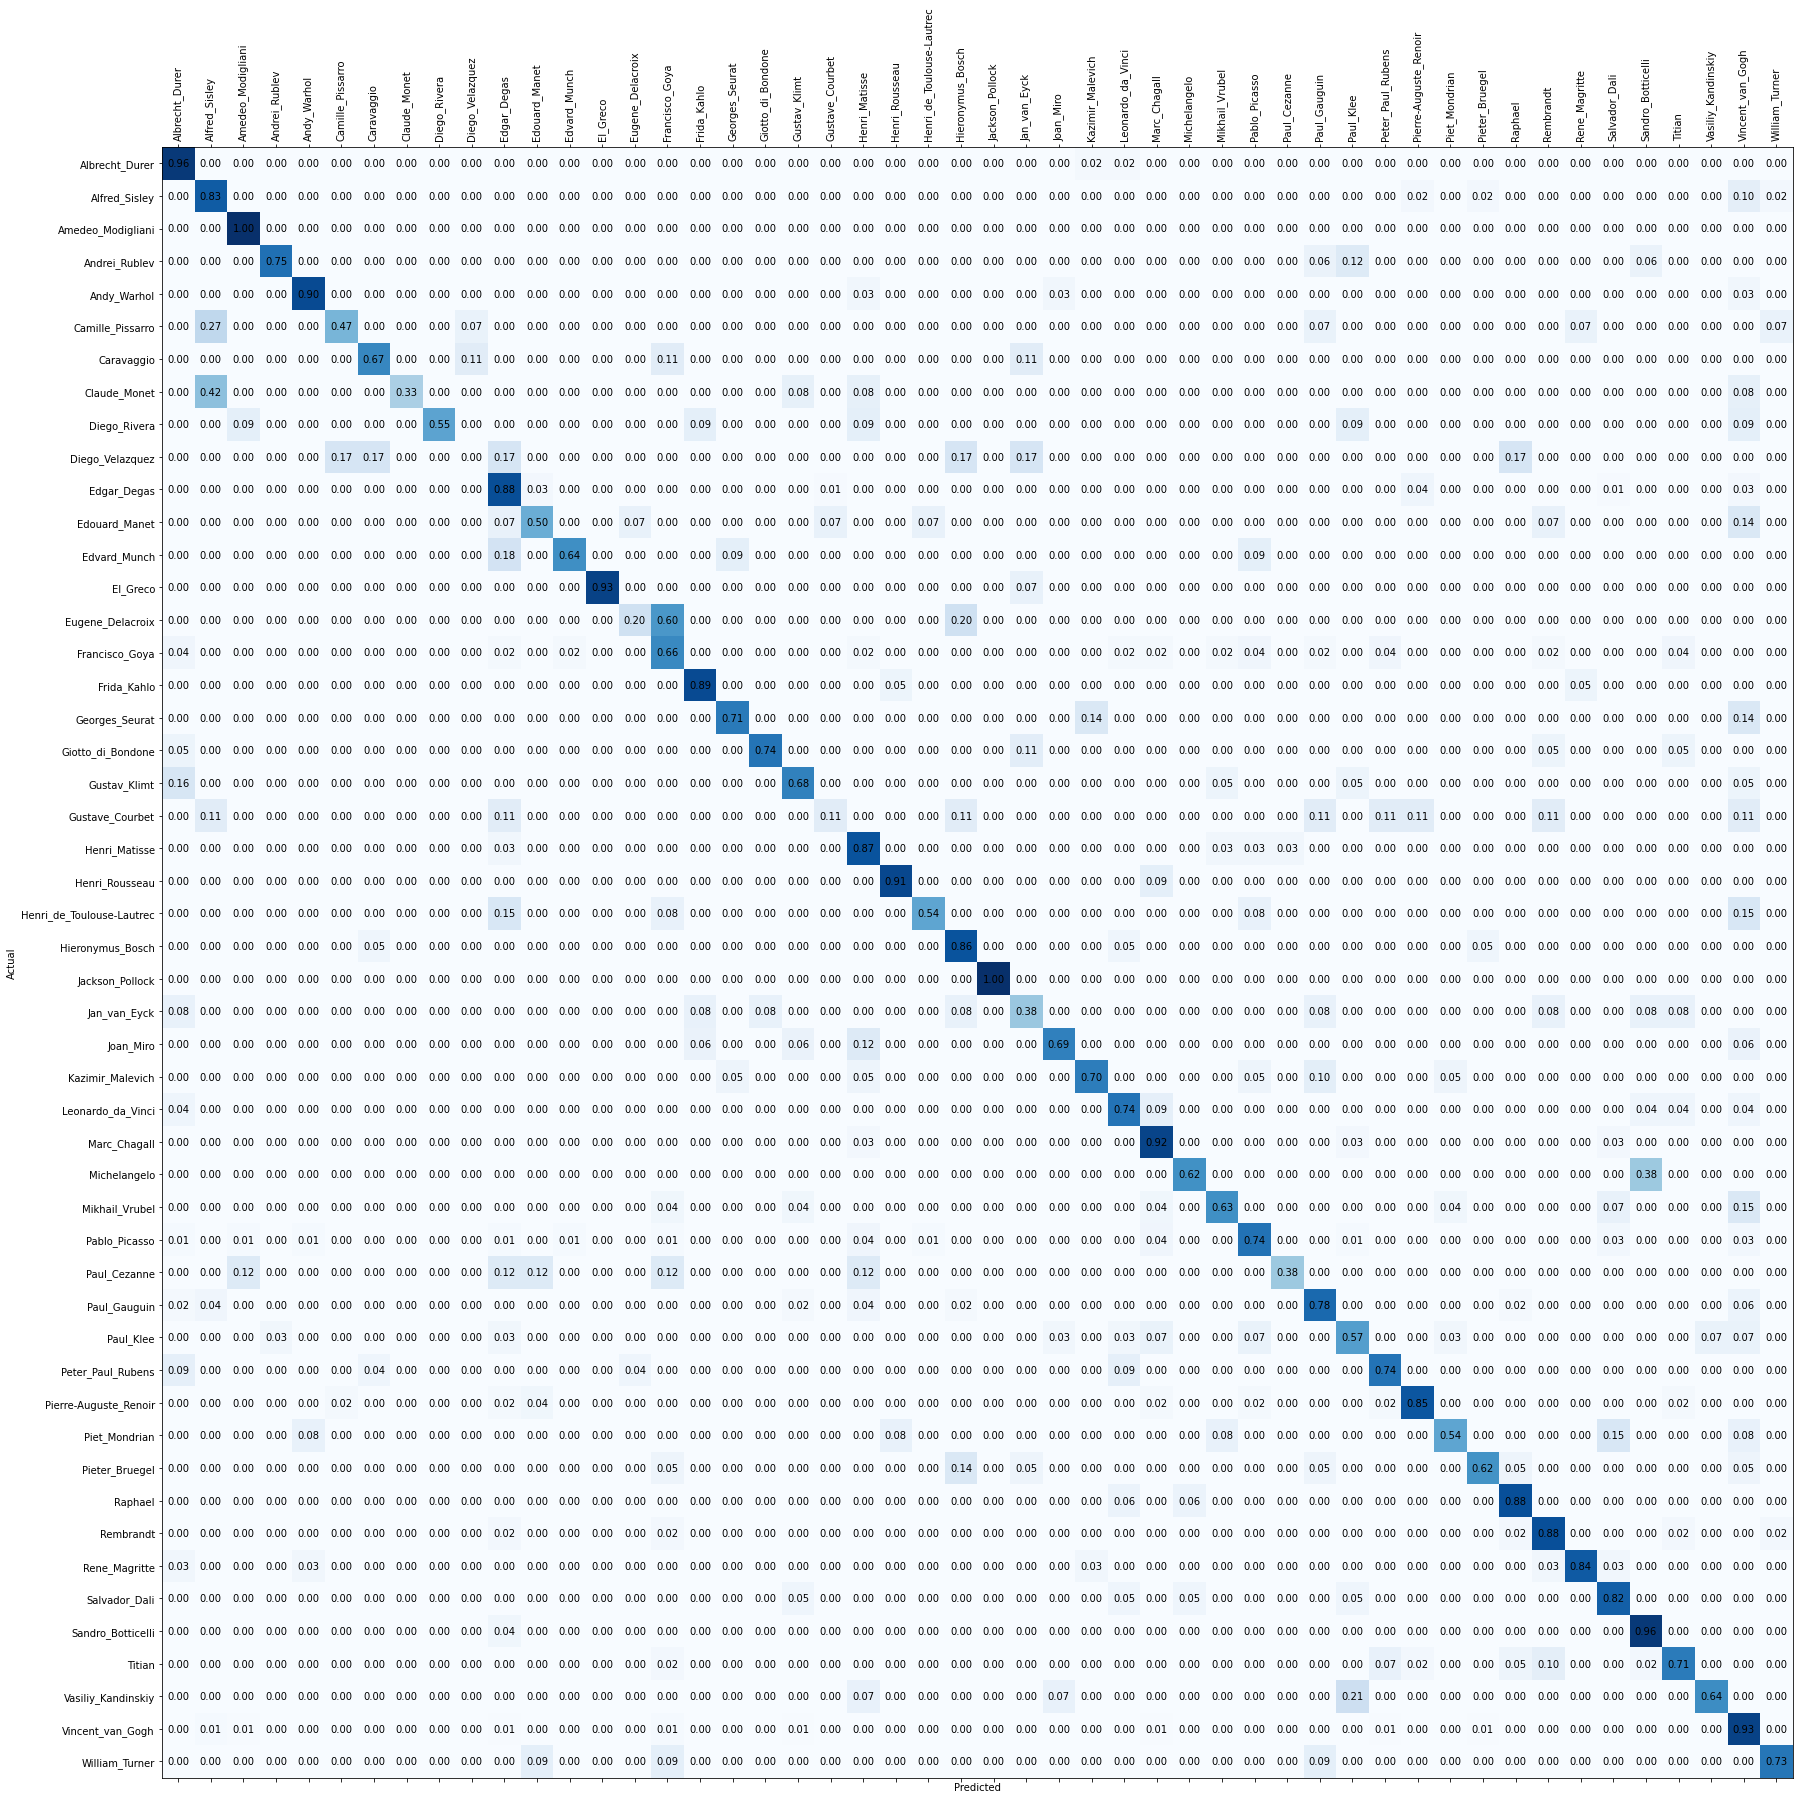

In [120]:
print("Validate Accuracy:", (calc_accuracy(validate_predictions)))

print_confusion_matrix(validate_predictions)
print_classification_report(validate_predictions)

### Test Analysis

Test Accuracy: 0.7624177139437462


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

           Albrecht_Durer       0.86      0.94      0.90        66
            Alfred_Sisley       0.78      0.88      0.83        52
        Amedeo_Modigliani       0.85      0.90      0.88        39
            Andrei_Rublev       0.78      0.90      0.84        20
              Andy_Warhol       0.79      0.83      0.81        36
         Camille_Pissarro       0.67      0.56      0.61        18
               Caravaggio       0.64      0.82      0.72        11
             Claude_Monet       0.33      0.27      0.30        15
             Diego_Rivera       0.78      0.50      0.61        14
          Diego_Velazquez       0.33      0.14      0.20         7
              Edgar_Degas       0.87      0.92      0.89       140
            Edouard_Manet       0.58      0.39      0.47        18
             Edvard_Munch       0.57      0.62      0.59        13
                 El_Greco       0.76      0.94      0.84     

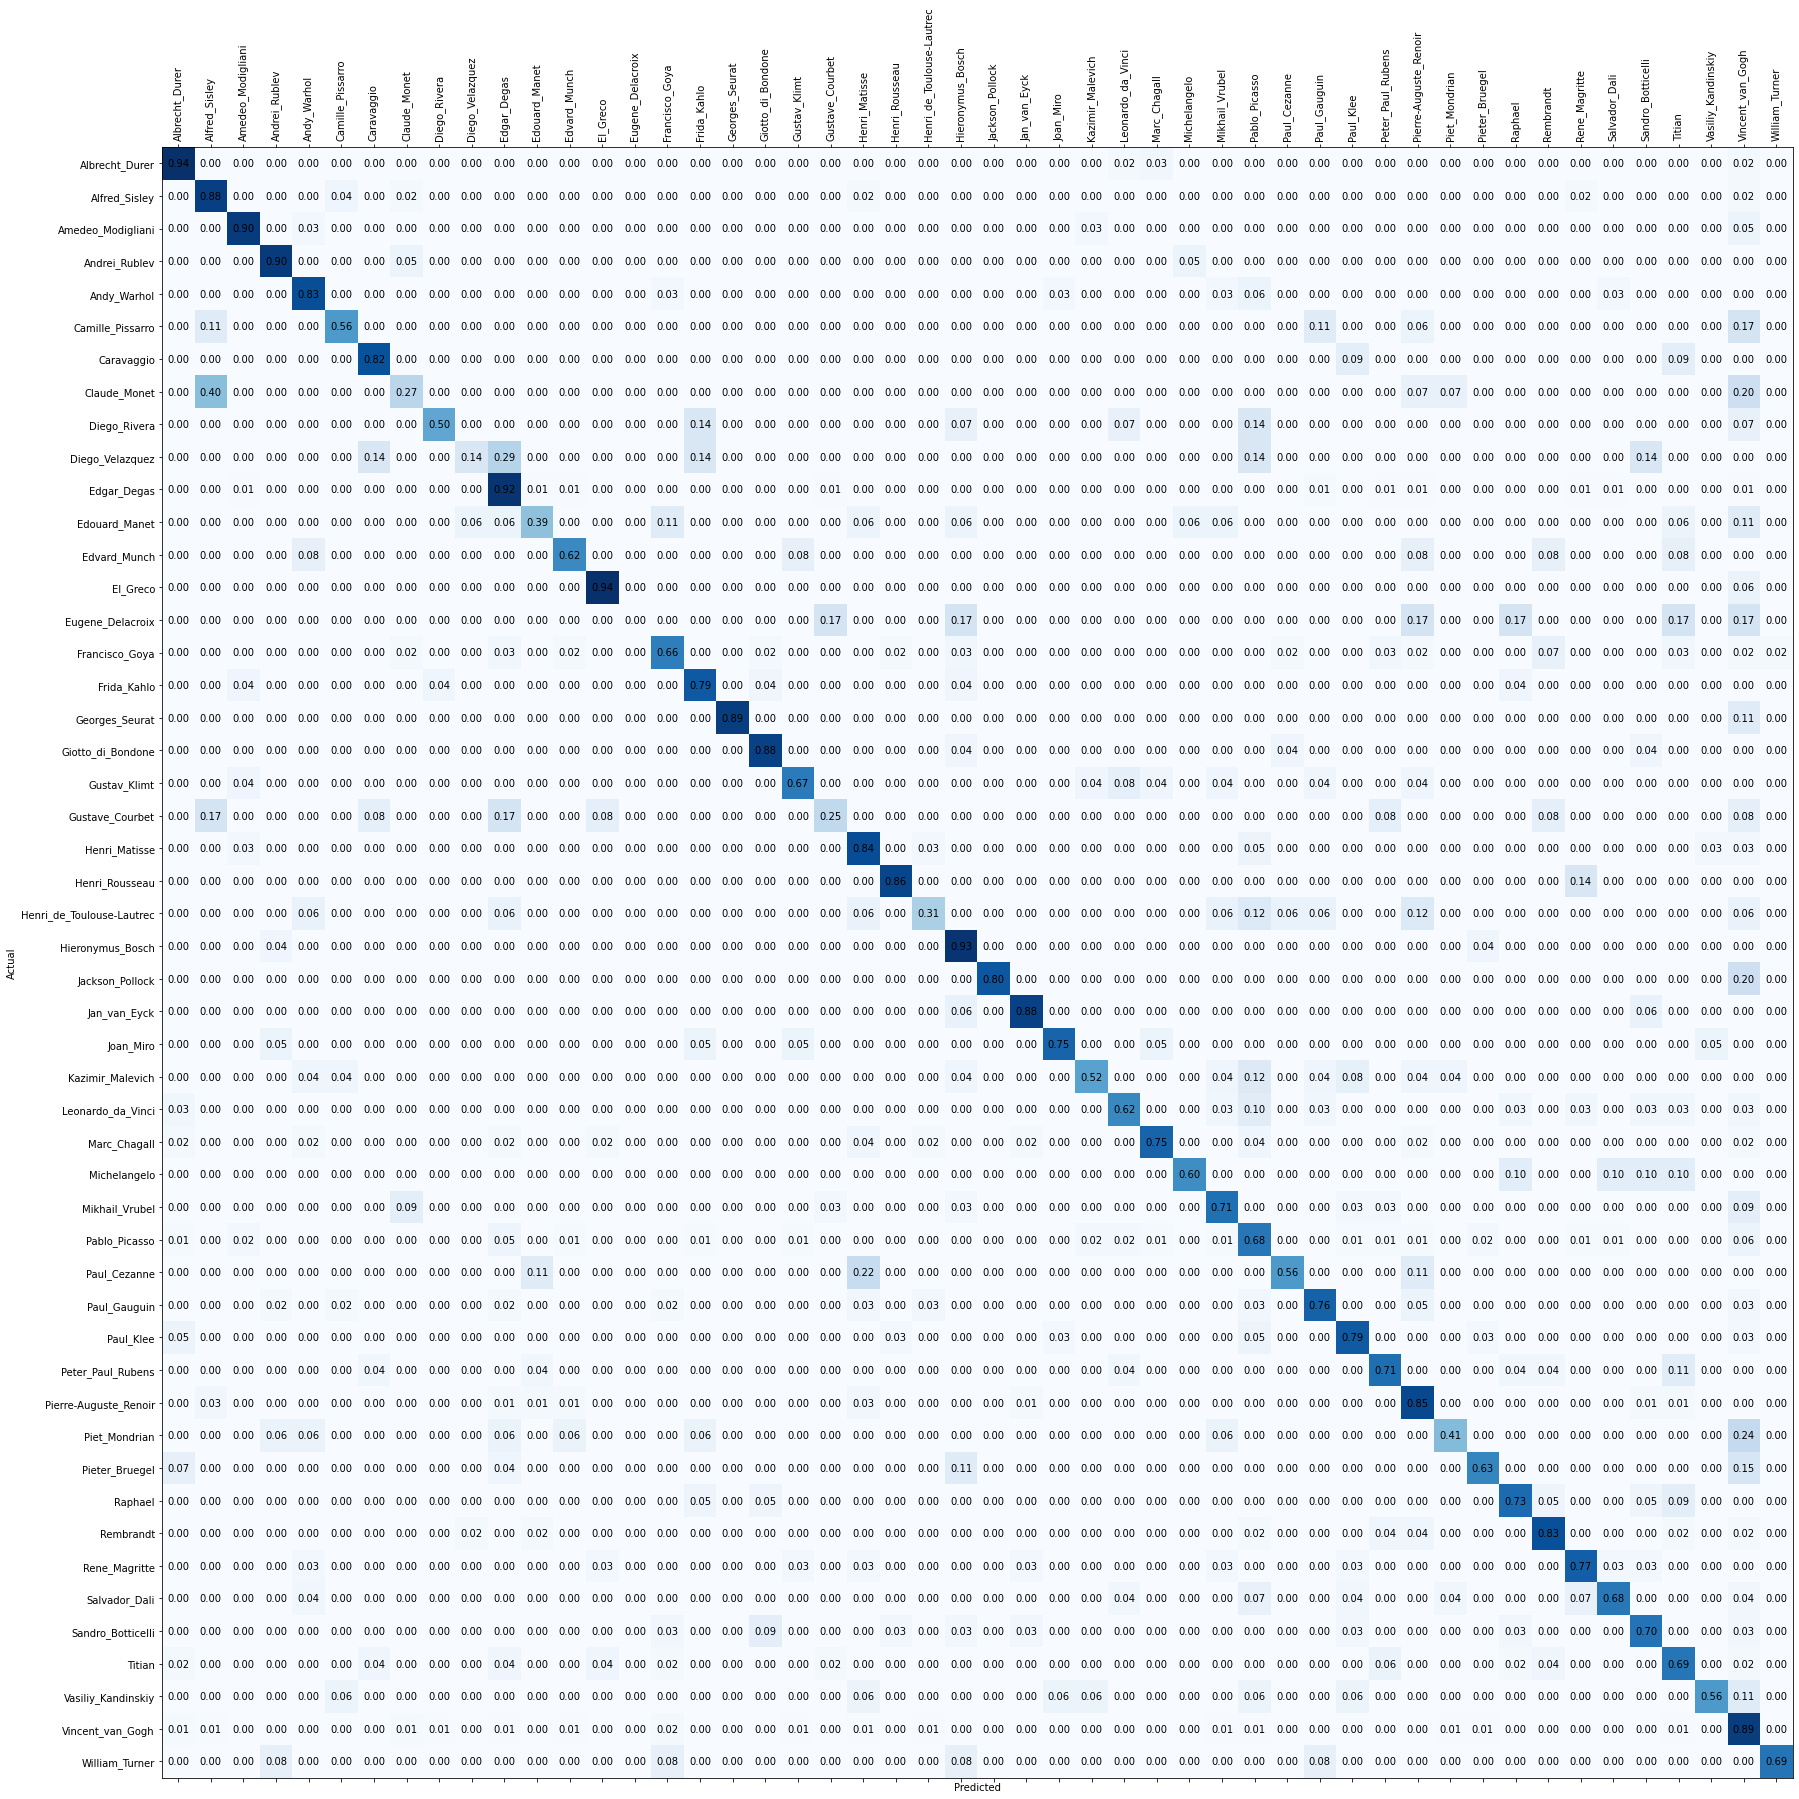

In [121]:
print("Test Accuracy:", (calc_accuracy(test_predictions)))
print_confusion_matrix(test_predictions)
print_classification_report(test_predictions)